In [12]:
import json
import ast
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation, CompoundLocation
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## Calculate Fst by comparing tip distances within a region to tip distances between regions

Fst = (piB - piW)/piB, where piB is the average of all pairwise distances Between regions, and piW is Within. 

Distances will be calculated between contemporary samples only (within 5 years)

Do this for RB protein

In [1]:
def readin_virus_config(virus):
    """
    Read in the config file for this virus to get the paths to alignment, metadata files, etc 
    as well as metadata about the virus such as how many subtypes, 
    and which genes are receptor-binding or polymerase
    """
    config_json = f'../config/adaptive_evo_config_{virus}.json'
    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [2]:
def subset_viruses_nextstrain_build(virus, subtype, gene, window, min_seqs=2, year_max=None, year_min=None):
    
    """
    Read in the alignment file for the specified virus and subtype, and extract the specified gene sequence. 
    Divide the alignment into temporal windows depending on the specified `window` argument (in years).
    
    For Fst calculations, return: 
    1. a dictionary of all time windows with at least 2 sequences, 
    where key is year window and value is list of strain names
    2. a dictionary mapping strain name to sequence
    3. a dictionary mapping strain name to region
    """
    
    configs = readin_virus_config(virus)
    
    #some dengue files are shared between all genotypes of the same serotype
    if virus=='dengue':
        serotype = subtype.split('_')[0]
    else:
        serotype = False
    
    subunit = False
    #find if gene is a subunit of surface protein
    if subtype==None:
        gene_location_key = "location"
    else:
        #dengue reference files and locations are shared among serotypes
        if serotype:
            gene_location_key = "location_"+str(serotype)
        else:
            gene_location_key = "location_"+str(subtype)
            
    if gene.upper() == configs['receptor_binding']['virus_gene'].upper():
        if "specify_location" in configs['receptor_binding'].keys():
            subunit = True
            parent_gene = configs['receptor_binding']['specify_location']['parent_gene']
            gene_location_list = ast.literal_eval(configs['receptor_binding']['specify_location'][gene_location_key])
    elif gene.upper() == configs['membrane_fusion']['virus_gene'].upper():
        if "specify_location" in configs['membrane_fusion'].keys():
            subunit = True
            parent_gene = configs['membrane_fusion']['specify_location']['parent_gene']
            gene_location_list = ast.literal_eval(configs['membrane_fusion']['specify_location'][gene_location_key])
        
    #Find reference, alignment and meta files (some sub-genic regions may use files from a gene or a whole genome)
    if subunit:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        #some are comma-separated, some are tab-separated
        metafile_sep = configs['metafile_sep']
    else:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=gene)
        metafile_sep = configs['metafile_sep']
        #dengue reference files are shared among serotypes
        if serotype:
            reference_file = configs['reference_file'].format(virus=virus, subtype=serotype, gene=gene)
        else:
            reference_file = configs['reference_file'].format(virus=virus, subtype=subtype, gene=gene)
    

    
    # if a minimum year to use is supplied in config, limit seqs to this
    if 'min_year' in configs.keys():
        year_min = int(configs['min_year'])
    
    #Find gene location, if domain is sub-genic or reference file contains multiple genes
    gene_location = False
    #If domain is sub-genic, fetch its position (within genome or parent gene) from config file

    if subunit:
        #Need to deal with domains the are not contiguous
        if len(gene_location_list)==1:
            gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))
        else:
            compound_locations = []
            for location in gene_location_list:
                compound_locations.append(FeatureLocation(location[0], location[1]))
            gene_location = CompoundLocation(compound_locations)

    #for reference files where the gene is named differently
    #like for fluC, where the segment is NS, but it contains NS1 and NS2
    elif 'specify_locations' in configs.keys() and gene in configs['specify_locations'].keys():       
        gene_location_list = ast.literal_eval(configs['specify_locations'][gene])
        gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))

    #Find gene location from reference files
    else:
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if 'gene' in feature.qualifiers.keys():
                        if feature.qualifiers['gene'][0].lower() == gene.lower():
                            gene_location = feature.location
                    if gene_location==False:
                        if 'product' in feature.qualifiers.keys():
                            if feature.qualifiers['product'][0].lower() == gene.lower():
                                gene_location = feature.location
                    if gene_location == False:
                        if 'locus_tag' in feature.qualifiers.keys():
                            if feature.qualifiers['locus_tag'][0].lower() == gene.lower():
                                gene_location = feature.location  
                        

    #Subset data based on time windows
    meta = pd.read_csv(meta_file, sep = metafile_sep)
    #drop incomplete date data
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta = meta[meta["date"].str.contains("20XX")==False]
    meta = meta[meta["date"].str.contains("36-0")==False]
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    #Remove egg- and cell-passaged strains
    meta.drop(meta[meta['strain'].str[-4:]=='-egg'].index, inplace=True)
    meta.drop(meta[meta['strain'].str[-5:]=='-cell'].index, inplace=True)
    
    #Limit meta data to only strains in alignment file
    aligned_isolates = []
    with open(alignment_file, "r") as aligned_handle:
        for isolate in SeqIO.parse(aligned_handle, "fasta"):
            aligned_isolates.append(isolate.id)
    aligned_isolates_df = pd.DataFrame(aligned_isolates, columns=['strain'])
    meta = meta.merge(aligned_isolates_df, on='strain', how='inner')
    
    
    #Group viruses by time windows
    virus_time_subset = {}

    date_window_start = meta['year'].min()
    date_window_end = meta['year'].min() + window
    while date_window_end <= meta['year'].max():
        years = str(date_window_start) + '-' + str(date_window_end)
        strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
        virus_time_subset[years] = strains

        #sliding window
        date_window_end += 1
        date_window_start += 1 
        
    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}
    
    # get list of all strains
    all_strains = [x for k,v in virus_time_subset.items() for x in v]

    # get rid of duplicate entries for same strain
    all_strains = list(set(all_strains))
    
    # map each strain name to the region it was from
    region_by_strain = {}
    count_strains_no_country = 0
    
    for s in all_strains:
        country = meta.loc[meta['strain']==s, 'country'].item()
        if country == 'None' or country == '?' or country == 'nan' or isinstance(country, float):
            count_strains_no_country+=1
            r = 'None'
        else:
            r = map_country_to_region(country)
        region_by_strain[s] = r
        
    # alert if there are a large number of sequences with no country info
    if count_strains_no_country >= len(all_strains)*0.3:
        print('lots of missing country info')
    
    
    # map each strain to its sequence
    sequence_by_strain = {}
    for s in all_strains:
        with open(alignment_file, "r") as aligned_handle:
            for isolate in SeqIO.parse(aligned_handle, "fasta"):
                if isolate.id == s:
                    if gene_location:
                        sequence_by_strain[s] = gene_location.extract(isolate.seq)
                    else:
                        sequence_by_strain[s] = isolate.seq
                        
    # get a list of all year windows
    year_windows = list(virus_time_subset.keys())

        
    return virus_time_subset, sequence_by_strain, region_by_strain, year_windows 
    

In [3]:
def map_country_to_region(seq_country):
    """
    Given a country, return a region
    """
    
    location_heirarchy = pd.read_csv('pairwise_distances_Fst/location_hierarchy.tsv', sep='\t', usecols=[0,1])
    
    location_lookup = dict(zip(location_heirarchy.country, location_heirarchy.region))

    # take care of special cases of country naming
    if seq_country == 'Usa':
        seq_country = 'USA'
    elif ':' in seq_country:
        seq_country = seq_country.split(':')[0]
    elif seq_country in ['New_Zealand', 'United_Kingdom', 'Viet_Nam', 'South_Korea', 
                         'South_Africa', 'French_Guiana', 'Czech_Republic']:
        seq_country = seq_country.replace('_', ' ')
    if seq_country == 'Viet Nam':
        seq_country = 'Vietnam'
    elif seq_country =='Hong_Kong':
         seq_country = 'China'
    # for unlisted countries, give another country name in the same region as a hack
    elif seq_country in ['New Caledonia', 'American Samoa', 'Northern Mariana Islands', 'Wallis And Futuna']:
        seq_country = 'New Zealand'
    elif seq_country in ['Puerto Rico', 'Saint Kitts', 'Trinidad And Tobago', 'Anguilla']:
        seq_country = 'Haiti'
    elif seq_country in ['Cote D Ivoire', 'Congo', 'Cape Verde', 'Swaziland', 'Burkina_Faso', 'Mayotte']:
        seq_country = 'Liberia'
    elif seq_country == 'Bhutan':
        seq_country = 'Nepal'
    elif seq_country == 'Macedonia':
        seq_country = 'Albania'
    elif seq_country == 'East Timor':
        seq_country = 'Indonesia'

    region = location_lookup[seq_country]
        
    return region

In [4]:
def get_pairwise_distances(seq0, seq1):
    """
    For a pair sequences, get the nucleotide distance between them
    """

    sequenced_sites_count = 0
    differences_count = 0
    for i in range(len(seq0)):
        # only use sequenced sites
        if seq0[i] in ['A', 'C' ,'G', 'T'] and seq1[i] in ['A', 'C' ,'G', 'T']:
            sequenced_sites_count+=1
            if seq0[i] != seq1[i]:
                differences_count+=1
    #only use isolates that were sequenced
    if sequenced_sites_count >0:
        pairwise_distance = differences_count/sequenced_sites_count
    else:
        pairwise_distance = 'N/A'

    return pairwise_distance

In [5]:
def calc_piB_piW(virus, subtype, gene, window):
    """
    For contemporary viruses (within 5 years of each other), get pairwise nucleotide distances
    and add these to running lists of pi depending on whether the isolates are from the 
    same region (piW) or different regions (piB)
    """

    virus_time_subset, sequence_by_strain, region_by_strain, year_windows = subset_viruses_nextstrain_build(virus, 
                                                                                                             subtype, 
                                                                                                             gene, 
                                                                                                            window)
    # initiate lists to store distances between tips in same region (piW), or in different regions (piB)
    # keep track of which region, or between-regions so that averages can be done separately for each
    all_regions = ['Africa', 'Asia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica']
    piW = []
    piB = []
    # get all region combos
    regioncombos = [f'{x[0]}_{x[1]}' for x in list(combinations(all_regions, 2))]
    piW_byregion = {r:[] for r in all_regions}
    piB_byregions = {rc:[] for rc in regioncombos}
    
    # for each time window, find sequences within same region, and those between
    # then calculate pairwise distances
    for timeWindow, strains in virus_time_subset.items():
        
        # get all pairs
        pairs = list(combinations(strains, 2))
        # for each pair, find genetic distance, then find whether they are in the same region 
        # and add pi to appropriate list
        for p in pairs:
            p0_seq = sequence_by_strain[p[0]]
            p1_seq = sequence_by_strain[p[1]]
            pairwise_distance = get_pairwise_distances(p0_seq, p1_seq)
            
            # only use strains that were sequenced
            if pairwise_distance != 'N/A':
                
                #remove whitespace from region names
                p0_region = region_by_strain[p[0]].replace(' ', '')
                p1_region = region_by_strain[p[1]].replace(' ', '')
                # only use pairs where both regions are known
                if p0_region!='None' and p1_region!='None':
                    # check whether or not they are from the same region
                    if p0_region == p1_region:
                        piW.append(pairwise_distance)
                        piW_byregion[p0_region].append(pairwise_distance)
                    else:
                        piB.append(pairwise_distance)
                        region_pair_key = '_'.join(sorted([p0_region, p1_region]))
                        piB_byregions[region_pair_key].append(pairwise_distance)
                        
    return piW, piB, piW_byregion, piB_byregions

In [6]:
def calc_Fst(virus, subtype, gene, window):
    """
    Calculate Fst as (avg(piB)-avg(piW)) / avg(piB), 
    where piW is all pairwise nucleotide distances of contemporaneous sequences in the same region
    and piB is all pairwise nucleotide distances of contemporaneous sequences in different regions
    """
    
    saved_data_name = f'pairwise_distances_Fst/{virus}_{subtype}_{window}yr_fst.json'
    
    #if distances are already computed, read in results
    if path.exists(saved_data_name):
        with open(saved_data_name) as json_handle:
            json_dict = json.load(json_handle)
            (Fst, Fst_by_region) = (json_dict['Fst'], json_dict['Fst_by_region'])
            
    #otherwise, compute them
    else:
        piW, piB, piW_byregion, piB_byregion = calc_piB_piW(virus, subtype, gene, window)

        mean_piW = sum(piW)/len(piW)
        mean_piB = sum(piB)/len(piB)
        
        # get the average pi for each region, then average all regions (to avoid biasing towards oversampled regions)
        avg_piW_per_region = []
        for reg, pis in piW_byregion.items():
            if len(pis)!=0:
                avg_piW_per_region.append(sum(pis)/len(pis))
        mean_piW_by_region = sum(avg_piW_per_region)/len(avg_piW_per_region)
        
        avg_piB_per_region = []
        for reg, pis in piB_byregion.items():
            if len(pis) !=0:
                avg_piB_per_region.append(sum(pis)/len(pis))
        mean_piB_by_region = sum(avg_piB_per_region)/len(avg_piB_per_region)

        Fst = (mean_piB - mean_piW) / mean_piB
        
        Fst_by_region = (mean_piB_by_region - mean_piW_by_region) / mean_piB_by_region
        
        save_data = {'virus': virus, 'subtype': subtype, 'gene': gene, 'window_length': f'{window}years',
                     'piW': piW, 'piB': piB, 'piW_byregion': piW_byregion, 'piB_byregion': piB_byregion, 
                     'Fst': Fst, 'Fst_by_region': Fst_by_region}
        
        with open(saved_data_name, 'w') as outfile:
            json.dump(save_data, outfile)
    
    return Fst, Fst_by_region

In [7]:
# list parameters to get fst for each virus and organize into a table
viruses_and_gene = [['h3n2', None, 'ha1'], ['h1n1pdm', None, 'ha1'], ['vic', None, 'ha1'], 
                    ['yam', None, 'ha1'], 
                   ['rsv', 'B', 'G'], ['rsv', 'A', 'G'], ['parainfluenza', '1', 'HN'], ['measles', None, 'H'], 
                    ['parainfluenza', '3', 'HN'], 
                    ['dengue', 'denv2_AA', 'E'], ['dengue', 'denv4_II', 'E'], 
                    ['dengue', 'denv3_III', 'E'], ['dengue', 'denv1_V', 'E'], 
                    ['oc43', 'A', 's1'], ['229e', None, 's1'], ['nl63', None, 's1'], 
                    ['rotavirusAg1p8', None, 'P'], ['rotavirusAg1p4', None, 'P'], 
                    ['norovirus', None, 'VP1'], ['enterovirusd68', None, 'VP1'], 
                    ['hepatitisA_IA', None, 'VP1'], ['hepatitisB', 'A2', 'Large'], ['hepatitisB', 'D3', 'Large'],
                    ['parvovirusB19', None, 'VP1'], ['adenovirusB7', None, 'Fiber'], ['adenovirusB3', None, 'Fiber']]

In [8]:
virus_name_legible = {'h3n2': 'Influenza A/H3N2', 'h1n1pdm': 'Influenza A/H1N1pdm', 
                      'vic':'Influenza B/Vic', 'yam': 'Influenza B/Yam', 
                      'influenzaC_Yamagata': 'Influenza C/Yamagata',
                      '229e': 'CoV 229E', 'oc43_A': 'CoV OC43-A', 'nl63': 'CoV NL63',
                      'norovirus': 'Norovirus GII.4', 'enterovirusd68': 'Enterovirus D68', 
                      'rsv_A': 'RSV-A', 'rsv_B': 'RSV-B', 'measles': 'Measles', 'mumps':'Mumps', 
                      'parainfluenza_1':'Parainfluenza-1', 'parainfluenza_3':'Parainfluenza-3',
                      'dengue_denv1_V': 'Dengue 1-V', 'dengue1_V': 'Dengue 1-V', 
                      'dengue_denv2_AA': 'Dengue 2-AA','dengue2_AA': 'Dengue 2-AA',
                      'dengue_denv3_III': 'Dengue 3-III', 'dengue3_III': 'Dengue 3-III',
                      'dengue_denv4_II': 'Dengue 4-II', 'dengue4_II': 'Dengue 4-II', 
                      'rotavirusAg1p8':'Rotavirus A/P[8]', 'rotavirusAg1p4':'Rotavirus A/P[4]', 
                      'hepatitisA_IA': 'HepatitisA-IA', 
                      'hepatitisB_D3':'Hepatitis B-D3', 'hepatitisB_A2':'Hepatitis B-A2', 
                      'adenovirusB3': 'Adenovirus B-3', 'adenovirusB7': 'Adenovirus B-7', 
                      'parvovirusB19': 'Parvovirus B19-1A'}

In [14]:
def make_fst_table(viruses, fst_window):
    """
    """
    info_for_table = []
    
    for v in viruses:
        if v[1] == None:
            legible_virus = virus_name_legible[v[0]]
        else:
            legible_virus = virus_name_legible[f'{v[0]}_{v[1]}']
        Fst, Fst_by_region = calc_Fst(v[0], v[1], v[2], fst_window)
        info_for_table.append({'virus': legible_virus, 'Fst': Fst_by_region})
        
    df = pd.DataFrame(info_for_table)
    print(df)

In [15]:
make_fst_table(viruses_and_gene, 1)

                  virus       Fst
0      Influenza A/H3N2  0.118928
1   Influenza A/H1N1pdm  0.153999
2       Influenza B/Vic  0.083206
3       Influenza B/Yam  0.147121
4                 RSV-B  0.300597
5                 RSV-A  0.235364
6       Parainfluenza-1  0.096723
7               Measles  0.258777
8       Parainfluenza-3  0.288524
9           Dengue 2-AA  0.650420
10          Dengue 4-II  0.840773
11         Dengue 3-III  0.746799
12           Dengue 1-V  0.615351
13           CoV OC43-A  0.567879
14             CoV 229E  0.574191
15             CoV NL63  0.367208
16     Rotavirus A/P[8]  0.334572
17     Rotavirus A/P[4]  0.499217
18      Norovirus GII.4  0.222610
19      Enterovirus D68  0.502243
20        HepatitisA-IA  0.510844
21       Hepatitis B-A2  0.105170
22       Hepatitis B-D3  0.263078
23    Parvovirus B19-1A  0.170917
24       Adenovirus B-7  0.674723
25       Adenovirus B-3  0.491295


In [16]:
#get the rate of adaptation for each virus
all_viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC_Yamagata',
               '229e', 'oc43_A', 'nl63', 'enterovirusd68', 'norovirus',
               'rsv_A', 'rsv_B', 'measles', 'mumps', 
               'parainfluenza_1', 'parainfluenza_3', 
               'dengue1_V','dengue2_AA', 'dengue3_III','dengue4_II',
               'rotavirusAg1p4', 'rotavirusAg1p8', 'hepatitisA_IA', 
               'hepatitisB_D3', 'hepatitisB_A2', 'adenovirusB3', 'adenovirusB7', 'parvovirusB19']

#name of RB protein
rb_protein = {'sars2':'S1', 'sars2_21L':'S1', 
              'h3n2': 'HA1', 'h1n1pdm': 'HA1', 'influenzaC_Yamagata': 'HEF1',
              'vic':'HA1', 'yam': 'HA1', 
              '229e': 'S1', 'oc43_A': 's1', 'nl63':'S1',
              'norovirus': "VP1", 'enterovirusd68': "VP1", 
              'rsv_A': "G", 'rsv_B': "G", 
              'measles': "H", 'mumps': "HN", 
              'parainfluenza_1':"HN", 'parainfluenza_3':"HN", 
              'dengue1_V': "E",'dengue2_AA': "E",'dengue3_III': "E",'dengue4_II': "E",
              'rotavirusAg1p8':"VP4", 'rotavirusAg1p4':"VP4", 
              'hepatitisA_IA': "VP1", 'hepatitisB_D3': "Large", 'hepatitisB_A2':"Large", 
              'adenovirusB7': "fiber", 'adenovirusB3': "fiber", 'parvovirusB19':"VP1"}

adaptation_rates = {}

for virus in all_viruses:
    window, min_seqs = 5, 3
    if virus in ['h1n1pdm', 'mumps']:
        window, min_seqs = 3, 3
    if 'dengue' in virus:
        virus_name = 'dengue_denv'+str(virus.split('dengue')[1])
    else:
        virus_name = virus
    if 'rotavirus' in virus:
        json_name = f'../adaptation_results/results/{virus_name}_P_{window}_{min_seqs}_adaptation_bootstrapped.json'

    else:
        json_name = f'../adaptation_results/results/{virus_name}_{rb_protein[virus]}_{window}_{min_seqs}_adaptation_bootstrapped.json'
    if path.exists(json_name):
        with open(json_name) as json_handle:
            json_dict = json.load(json_handle)
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation, bootstrap_adaptive_substitutions, 
             bootstrap_adaptive_substitutions_per_codon, 
             bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)
        
        legible_name = virus_name_legible[virus_name]

        adaptation_rates[legible_name] = rate_of_adaptation* (10**3)

In [18]:
#read in colors from the manuscript_colors config file
color_config_json = f'../config/manuscript_colors.json'
with open(color_config_json) as json_handle:
    colors = json.load(json_handle)

colors['colors']['dengue_denv1_V'] = colors['colors']['dengue1_V']
colors['colors']['dengue_denv2_AA'] = colors['colors']['dengue2_AA']
colors['colors']['dengue_denv3_III'] = colors['colors']['dengue3_III']
colors['colors']['dengue_denv4_II'] = colors['colors']['dengue4_II']

In [19]:
#read in aa sub rates
with open('../adaptation_results/aasubrates.json', 'r') as openfile:
    # Reading from json file
    aasub_rates = json.load(openfile)
    
aasub_rates_by_virus = {virus_name_legible[k]:v for k, v in aasub_rates.items()}

In [20]:
def compare_fst_vs_subs_adaptation(fst_window=1, filename=False):
    """
    Plot Fst vs. rate of amino acid substitution and Fst vs. rate of adaptation
    """
    
    

    # make a scatterplot of rate of adaptation vs Fst (1-year window)
    info_for_plot = []
    
    cmap = {}

    for v in viruses_and_gene:
        if v[1] == None:
            legible_virus = virus_name_legible[v[0]]
            virus_color = colors['colors'][v[0]]
        else:
            legible_virus = virus_name_legible[f'{v[0]}_{v[1]}']
            virus_color = colors['colors'][f'{v[0]}_{v[1]}']
        Fst, Fst_by_region = calc_Fst(v[0], v[1], v[2], fst_window)
        cmap[legible_virus] = virus_color
        info_for_plot.append({'virus': legible_virus, 'Fst': Fst_by_region, 
                              'Adaptation': adaptation_rates[legible_virus], 
                              'Substitution': aasub_rates_by_virus[legible_virus], 
                              'color':virus_color})
    fst_adaptation_df = pd.DataFrame(info_for_plot)


    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['figure.dpi']= 300

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    
    sns.scatterplot(x='Fst', y='Substitution', hue='virus', palette=cmap, s=70,
                    data = fst_adaptation_df, 
                    ax=ax1, legend=False)
    sns.scatterplot(x='Fst', y='Adaptation', hue='virus', palette=cmap, s=70,
                    data = fst_adaptation_df, 
                    ax=ax2, legend=False)
    
    panel_labels = {ax1:'A', ax2:'B'}
    for ax in [ax1, ax2]:
        ax.text(-0.02, 1.06, panel_labels[ax], horizontalalignment='center', 
                       verticalalignment='center', weight='bold', fontsize=14, transform=ax.transAxes)
    ax1.set_ylabel('Amino Acid Subs per Residue\nper Year $(× 10^{-3})$')
    ax2.set_ylabel('Adaptive Muts per Codon\nper Year $(× 10^{-3})$')
    ax1.set_xlabel(f'Fst, {fst_window}-year windows')
    ax2.set_xlabel(f'Fst, {fst_window}-year windows')
    
    r_substitution = scipy.stats.pearsonr(x=fst_adaptation_df['Fst'], y=fst_adaptation_df['Substitution'])[0]
    ax1.text(0.5, 0.8, f'r = {round(r_substitution,2)}', fontsize=14, horizontalalignment='left', 
                   verticalalignment='center', transform=ax1.transAxes)

    r_adaptation = scipy.stats.pearsonr(x=fst_adaptation_df['Fst'], y=fst_adaptation_df['Adaptation'])[0]
    ax2.text(0.5, 0.8, f'r = {round(r_adaptation,2)}', fontsize=14, horizontalalignment='left', 
                   verticalalignment='center', transform=ax2.transAxes)
    
    sns.despine()


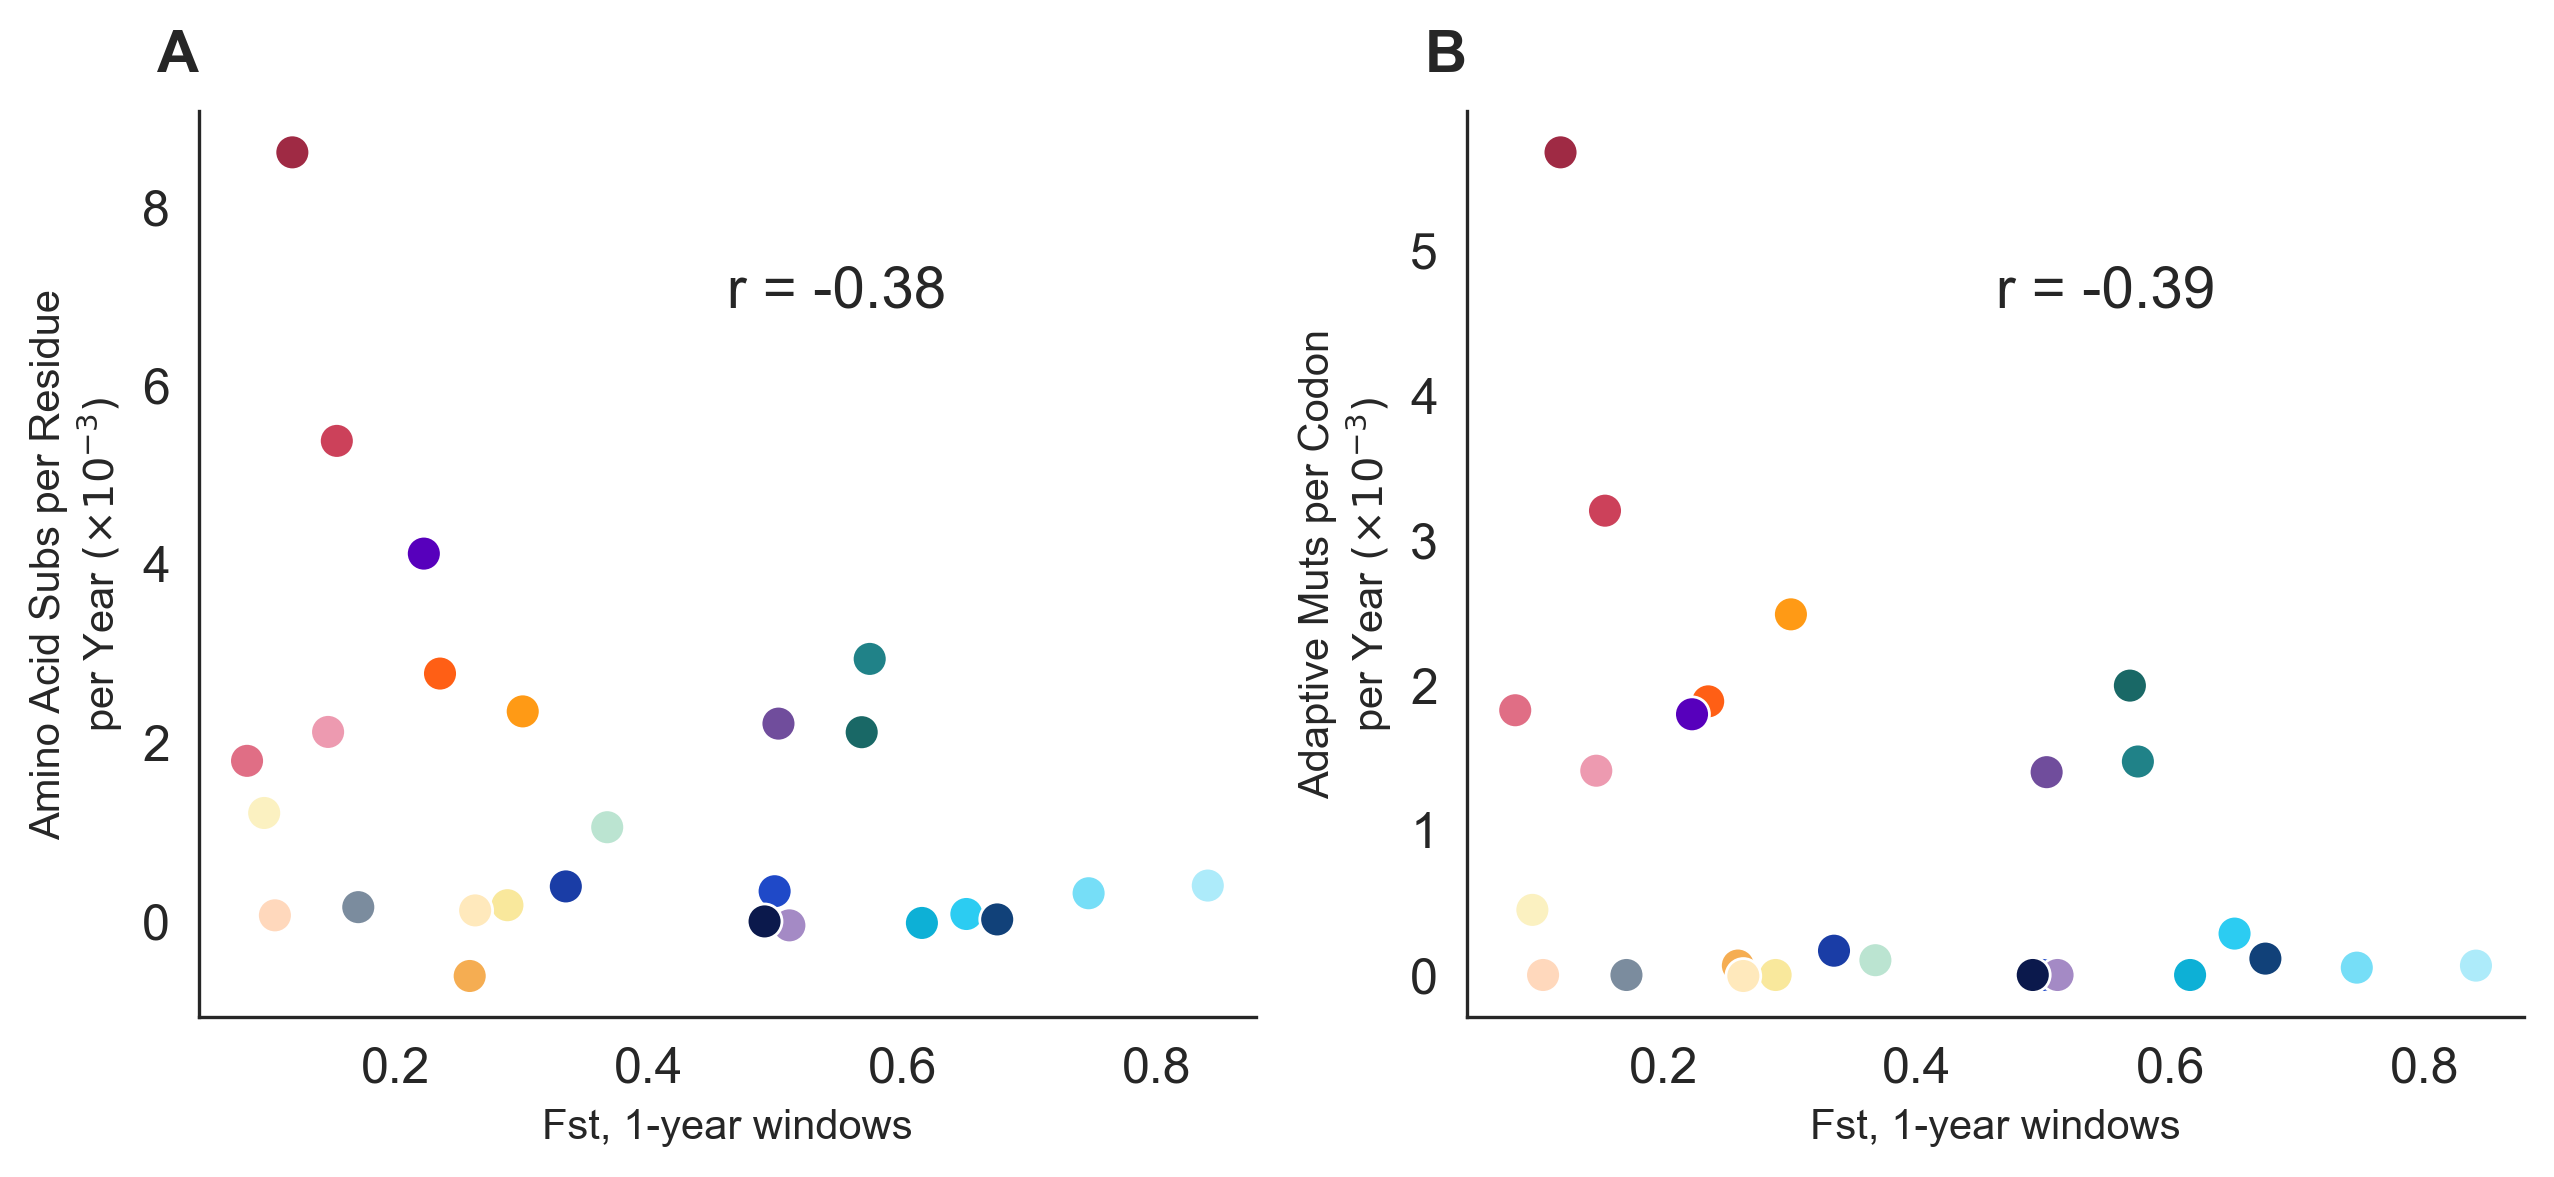

In [22]:
compare_fst_vs_subs_adaptation()